<a href="https://colab.research.google.com/github/Ayesha-Imr/Graph-RAG-Automation-ApertureDB-Gemini/blob/main/Notebooks/LOCAL_GraphRAG_with_ApertureDB_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GraphRAG with ApertureDB: Part 2 - Implementing and Evaluating Graph RAG

Welcome to the second part of our tutorial! In [Part 1](https://colab.research.google.com/drive/1KTAa5n-v_8casxUrxP4PZVqOUbVwYo6I#scrollTo=O3sqCMumwRje), we successfully built a knowledge graph from a PDF document and ingested it into ApertureDB. Now, we'll put that graph to work.

Our goal is to build a Q&A system using two different Retrieval-Augmented Generation (RAG) methods and compare their performance.

1.  **Vanilla RAG:** A standard approach using pure vector search to find relevant information.
2.  **Graph RAG:** A more advanced method that leverages the connections within our knowledge graph to find richer, more contextual information.

## 1. Environment Setup

First, let's install the necessary libraries and set up our clients for [ApertureDB](https://www.aperturedata.io/) and Google's [Gemini](https://ai.google.dev/gemini-api/docs/models) models. We'll be using Gemini for both embedding our queries and for generating the final answers.

In [11]:
!pip install -q  aperturedb google-genai udocker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 4.1 MB/s eta 0:00:00


### Local ApertureDB session setup via udocker

This data is from the previous embeddings' ingestion [notenook](https://colab.research.google.com/drive/1KTAa5n-v_8casxUrxP4PZVqOUbVwYo6I#scrollTo=jOo1K_QHX6cT). We'll be using this to continue with our graph RAG implementation.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_ROOT = "/content/drive/MyDrive/aperturedb_data"

In [12]:
!udocker --allow-root install

Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful


In [13]:
!udocker --allow-root pull aperturedata/aperturedb-community:latest
!udocker --allow-root create --name=aperturedb aperturedata/aperturedb-community:latest

Info: downloading layer sha256:7c84311f635af4c4a0fec53e53c35b7b388a8b7e40025346a1d4af37423ea2c2
Info: downloading layer sha256:a6e6f81788d18a6a24869a662a78e4798c46eba38d0cca171080f1e131146a16
Info: downloading layer sha256:6c6f170a129049940a474f88f5fc649d7d96700ef0748bbc590476942c609949
Info: downloading layer sha256:9b3453b1064fb34bae3e701ecd6cfce41e99f8fc037857b7c9de26f917ad8840
Info: downloading layer sha256:5090e15fdc6a26ebc57cdfff090b7090d1020672ce22b4a290451acc9c16da6d
Info: downloading layer sha256:c2bf41e51776f1206dd05060633eada7174bc768aa6f062cc6fa3b5def95ca94
Info: downloading layer sha256:e17caecd6bd74e6c419f0d21e9522006fded22eedf72be6b9046819a6265903c
Info: downloading layer sha256:aece8493d3972efa43bfd4ee3cdba659c0f787f8f59c82fb3e48c87cbb22a12e
e39a128c-22da-3567-9f81-3a7f43d5bfcb


In [124]:
!nohup udocker --allow-root run \
    --publish=55555:55555 \
    --env="ADB_MASTER_KEY=admin" \
    --env="ADB_FORCE_SSL=false" \
    --volume=$DATA_ROOT/db:/aperturedb/db \
    aperturedb  > /content/adb_server.log 2>&1 &

In [125]:
import time
time.sleep(15)

In [126]:
!tail -n 15 /content/adb_server.log | sed -e 's/^/LOG │ /'

LOG │ ApertureDB Server, Version: 0.18.10, Branch: feature/community-docker, Commit: 728440c99395bca1a3346dc8e4d51917a8d16764


In [127]:
!lsof -nP -iTCP:55555

COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
apertured 14152 root   17u  IPv4 370868      0t0  TCP *:55555 (LISTEN)


Connect to ApertureDB client

In [128]:
from aperturedb import Connector
client = Connector.Connector(
    host="127.0.0.1", port=55555,
    user="admin",  password="admin",
    use_ssl=False
)
status = client.query([{"GetStatus": {}}], [])
print(status)

([{'GetStatus': {'info': 'OK', 'status': 0, 'system': 'ApertureDB', 'version': '0.18.10'}}], [])


Verify the existence of our data in the DB

In [67]:
schema = client.query([{"GetSchema": {}}], [])
print(schema)

([{'GetSchema': {'connections': {'classes': {'_DescriptorSetToDescriptor': {'dst': '_Descriptor', 'matched': 380, 'properties': None, 'src': '_DescriptorSet'}, 'abstracts': {'dst': 'Software', 'matched': 2, 'properties': {'created_at': [2, False, 'String'], 'dst_class': [2, False, 'String'], 'dst_id': [2, False, 'Number'], 'src_class': [2, False, 'String'], 'src_id': [2, False, 'Number'], 'type': [2, False, 'String']}, 'src': 'Software'}, 'accesses': {'dst': 'Software', 'matched': 1, 'properties': {'created_at': [1, False, 'String'], 'dst_class': [1, False, 'String'], 'dst_id': [1, False, 'Number'], 'src_class': [1, False, 'String'], 'src_id': [1, False, 'Number'], 'type': [1, False, 'String']}, 'src': 'User'}, 'acts_as': {'dst': 'Organization', 'matched': 1, 'properties': {'created_at': [1, False, 'String'], 'dst_class': [1, False, 'String'], 'dst_id': [1, False, 'Number'], 'src_class': [1, False, 'String'], 'src_id': [1, False, 'Number'], 'type': [1, False, 'String']}, 'src': 'Servic

In [20]:
# Core imports
import os
import json
import time
from typing import Dict, List, Any
from tqdm import tqdm
import numpy as np

# Data models and utilities
from pydantic import BaseModel, Field
from google.colab import userdata, files
from aperturedb.CommonLibrary import create_connector
from IPython.display import HTML, display
import pprint
from google import genai
from google.genai import types, errors

Set up the API keys. You can get a Google API key [here](https://aistudio.google.com/apikey).

In [21]:
google_api_key = userdata.get("GOOGLE_API_KEY")

## 2. Defining the Retrieval Logic

The core of any RAG system is the retrieval mechanism. Here, we define the main functions for both of our RAG approaches.

First, lets define the confgurations for our vector search system. We use Google's [`gemini-embedding-001`](https://ai.google.dev/gemini-api/docs/embeddings) embedding model here, with dimensions configured to 768 - same as our document embeddings' dimensions. It is necessary for these dimensions to match.

In [22]:
GEMINI_MODEL_NAME = "gemini-embedding-001"
EMBEDDING_DIMENSIONS = 768
gemini_client = genai.Client(api_key=google_api_key)
DESCRIPTOR_SET_NAME = "entity_embeddings_gemini"

Both of our RAG methods will start with a vector search to find initial, semantically relevant entities. This function takes a user's query, embeds it using the `gemini-embedding-001` model, and performs a K-Nearest Neighbor (KNN) search in ApertureDB to find the most similar entities in our knowledge base.

ApertureDB's ability to chain commands is powerful here: we first `FindDescriptor` to get the top K vectors, then immediately find the `Entity` connected to each vector via the `has_embedding` relationship, all in a single query.

In [23]:
def find_semantic_entry_points(query_text: str, k: int, client, gemini_client) -> List[Dict[str, Any]]:
    """
    Finds the top K most semantically relevant entities in the knowledge graph
    based on a user query using vector search and graph traversal.
    Uses Gemini for generating the embedding of the query.
    """
    # Create Gemini embedding config
    embed_cfg = types.EmbedContentConfig(
        output_dimensionality=EMBEDDING_DIMENSIONS,
        task_type="QUESTION_ANSWERING",  # since it's will be used for Q&A. RETRIEVAL_QUERY can also be used here.
    )

    # Get embedding from Gemini
    result = gemini_client.models.embed_content(
        model=GEMINI_MODEL_NAME,
        contents=[query_text],
        config=embed_cfg,
    )

    # Extract embedding
    query_embedding = result.embeddings[0].values
    query_embedding_bytes = np.array(query_embedding, dtype=np.float32).tobytes()

    # Execute a FindDescriptor KNN query and traverse to linked entities
    query = [
        {
            "FindDescriptor": {
                "set": DESCRIPTOR_SET_NAME,
                "k_neighbors": k,
                "distances": True,
                "blobs": False,
                "results": {
                    "all_properties": True
                },
                "_ref": 1,
            }
        },
        {
            "FindEntity": {
                "is_connected_to": {
                    "ref": 1,
                    "connection_class": "has_embedding",
                },
                "results": {
                    "all_properties": True
                },
            }
        },
    ]

    response, _ = client.query(query, [query_embedding_bytes])

    # Extract results
    descriptor_results = response[0].get("FindDescriptor", {}).get("entities", [])
    entity_results = response[1].get("FindEntity", {}).get("entities", [])

    # Map descriptor -> class, entity -> full data
    id_to_class_map = {
        d.get('source_entity_id'): d.get('source_entity_class')
        for d in descriptor_results
    }
    id_to_entity_data_map = {
        e.get('id'): e
        for e in entity_results
    }

    enriched_entities = []
    for descriptor_item in descriptor_results:
        entity_id = descriptor_item.get('source_entity_id')
        if entity_id in id_to_entity_data_map:
            entity_data = id_to_entity_data_map[entity_id].copy()
            entity_data['class'] = id_to_class_map.get(entity_id)
            enriched_entities.append(entity_data)

    return enriched_entities

 A helper function to format retreived entities into a string to be passed as context into an LLM prompt.

In [24]:
def _format_entity_properties(entity: Dict[str, Any]) -> str:
    """Helper to format entity properties into a string."""
    formatted_props = []
    entity_name = entity.get('name', f"Entity_{entity.get('id', 'Unknown')}")
    entity_class = entity.get('class', 'Unknown')

    formatted_props.append(f"Entity: '{entity_name}' (Class: '{entity_class}', ID: {entity.get('id', 'N/A')})")

    for key, value in entity.items():
        if not key.startswith('_') and key not in ['name', 'class', 'id', '_uniqueid']:
            if isinstance(value, (dict, list)):
                value_str = str(value)
            else:
                value_str = str(value)
            formatted_props.append(f"  - {key}: {value_str}")
    return "\n".join(formatted_props)

This is the key component of Graph RAG. Starting from the initial entities, this function traverses the graph outwards for a set number of `hops`, collecting connected entities and their relationships to build a rich, interconnected context.

In [25]:
def build_traversal_context(start_entities: List[Dict[str, Any]], max_hops: int, max_entities: int, client) -> str:
    """
    Performs a bounded BFS graph traversal from start_entities, collecting
    and formatting entities and connections into a context string.
    """
    context_strings: List[str] = []

    collected_entities: Dict[int, Dict[str, Any]] = {}
    collected_connections: List[Dict[str, Any]] = []

    explored_entity_ids: set = set()

    frontier_ids_for_current_hop: List[int] = []

    # Initialize the frontier with the starting entities
    frontier_ids_for_current_hop: List[int] = []

    for entity in start_entities:
        entity_id = entity.get("id")
        if entity_id is None or entity_id in explored_entity_ids:
            continue

        # Add the starting entity to the context and mark as explored
        context_strings.append(_format_entity_properties(entity))
        explored_entity_ids.add(entity_id)
        frontier_ids_for_current_hop.append(entity_id)
        collected_entities[entity_id] = entity

        if len(explored_entity_ids) >= max_entities:
            break

    # Perform BFS traversal up to max_hops
    for hop in range(1, max_hops + 1):
        if not frontier_ids_for_current_hop or len(explored_entity_ids) >= max_entities:
            break

        all_connections_this_hop: List[Dict[str, Any]] = []
        queries_for_this_hop = []
        # Build queries to find connections for entities in the current frontier
        for i, entity_id in enumerate(frontier_ids_for_current_hop):
            ref_id = i + 1
            entity_class = collected_entities[entity_id].get('class', 'Unknown')
            queries_for_this_hop.extend([
                {"FindEntity": {"with_class": entity_class, "constraints": {"id": ["==", entity_id]}, "_ref": ref_id}},
                {"FindConnection": {"src": ref_id, "results": {"all_properties": True}}},
                {"FindConnection": {"dst": ref_id, "results": {"all_properties": True}}}
            ])

        # Execute the queries to find connections
        responses, _ = client.query(queries_for_this_hop)

        # Collect unique connections found in this hop
        conn_uids_seen = set()
        for resp_block in responses:
            if "FindConnection" in resp_block and resp_block["FindConnection"].get("connections"):
                for conn in resp_block["FindConnection"]["connections"]:
                    if conn["_uniqueid"] not in conn_uids_seen:
                        all_connections_this_hop.append(conn)
                        conn_uids_seen.add(conn["_uniqueid"])

        collected_connections.extend(all_connections_this_hop)

        # Map entity IDs to their classes from the connections
        id_to_class_map = {}
        for conn in all_connections_this_hop:
            if conn.get('src_id') is not None and conn.get('src_class') is not None:
                id_to_class_map[conn['src_id']] = conn['src_class']
            if conn.get('dst_id') is not None and conn.get('dst_class') is not None:
                id_to_class_map[conn['dst_id']] = conn['dst_class']

        # Identify new entities to fetch in the next hop
        unique_new_entity_ids_to_fetch = set()
        for conn in all_connections_this_hop:
            src_id = conn.get("src_id")
            dst_id = conn.get("dst_id")

            # If source is in current frontier and destination is not explored, add destination
            if src_id in frontier_ids_for_current_hop and dst_id not in explored_entity_ids:
                unique_new_entity_ids_to_fetch.add(dst_id)
            # If destination is in current frontier and source is not explored, add source
            elif dst_id in frontier_ids_for_current_hop and src_id not in explored_entity_ids:
                unique_new_entity_ids_to_fetch.add(src_id)

        next_frontier_ids = []
        # Fetch new entities and add to context if within limits
        if unique_new_entity_ids_to_fetch:
            valid_ids_to_fetch = [id for id in list(unique_new_entity_ids_to_fetch) if id is not None]
            if not valid_ids_to_fetch: continue

            fetch_new_entities_query = [{"FindEntity": {"constraints": {"id": ["in", valid_ids_to_fetch]}, "results": {"all_properties": True}}}]
            fetch_responses, _ = client.query(fetch_new_entities_query)

            if fetch_responses and "FindEntity" in fetch_responses[0] and fetch_responses[0]["FindEntity"].get("entities"):
                for entity in fetch_responses[0]["FindEntity"]["entities"]:
                    if len(explored_entity_ids) >= max_entities: break
                    entity_id = entity.get("id")
                    if entity_id not in explored_entity_ids:
                        # Add entity class from the map if available
                        entity['class'] = id_to_class_map.get(entity_id, 'Unknown')

                        collected_entities[entity_id] = entity
                        explored_entity_ids.add(entity_id)
                        next_frontier_ids.append(entity_id)
                        context_strings.append(_format_entity_properties(entity))

        # Format and add connections to the context
        for conn in all_connections_this_hop:
            src_id = conn.get("src_id")
            dst_id = conn.get("dst_id")

            # Only add connection string if both entities are in the cache (meaning they were added to context)
            if src_id in collected_entities and dst_id in collected_entities:
                src_entity, dst_entity = collected_entities[src_id], collected_entities[dst_id]
                conn_class = conn.get("class") or conn.get("type", "related_to")
                conn_str = f"  - [{src_entity.get('name')}] --({conn_class})--> [{dst_entity.get('name')}]"
                if conn_str not in context_strings:
                    context_strings.append(conn_str)

        # Update the frontier for the next hop
        frontier_ids_for_current_hop = next_frontier_ids

    # Return the structured data along with the formatted string
    return ("\n".join(context_strings), collected_entities, collected_connections)

This function combines the semantic search and graph traversal steps into a single pipeline. It returns both the formatted text for the LLM and the structured data for visualization.

In [26]:
def graph_rag(query_text: str, k: int, max_hops: int, max_entities: int, client, gemini_client) -> tuple:
    """
    Performs a full Graph RAG retrieval.

    It first finds the top-k semantically similar entities, then performs a
    bounded graph traversal from those entry points to build a rich,
    interconnected context string.

    Returns a tuple containing:
    1. The formatted context string for the LLM.
    2. A dictionary of the entity objects found.
    3. A list of the connection objects found.
    """
    # Find the top K most relevant entry points in the graph.
    start_entities = find_semantic_entry_points(query_text, k, client, gemini_client)

    # Build the final context string by traversing the graph from those entry points.
    return build_traversal_context(
        start_entities=start_entities,
        max_hops=max_hops,
        max_entities=max_entities,
        client=client
    )

Let's run a test query. We'll start with `k=3` initial entities and traverse `2` hops, up to a maximum of `20` total entities. The output context includes both entity properties and the relationships between them.

In [27]:
query = "What does a hypervisor do?"
k_initial_entities = 3 # The number of initial entities to find
max_hops_config = 2 # The maximum depth for the traversal
max_entities_context_limit = 20 # The hard limit on the total number of entities

graph_rag_context, retrieved_entities, retrieved_connections = graph_rag(
    query_text=query,
    k=k_initial_entities,
    max_hops=max_hops_config,
    max_entities=max_entities_context_limit,
    client=client,
    gemini_client=gemini_client
)

print("--- Generated Graph RAG Context ---")
print(graph_rag_context)

--- Generated Graph RAG Context ---
Entity: 'Hypervisor' (Class: 'Software', ID: 202)
  - access_control: Hypervisors emulate hardware devices, allowing VMs to interact with peripherals.
  - command_execution_method: Privileged Instructions from guest VMs (e.g., hardware access) must go through
  - definition: a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.
  - device_mediation: Hypervisors emulate hardware devices, allowing VMs to interact with peripherals.
  - hardware_access_control: Ensures that instructions requiring hardware access execute under the hypervisor’s control.
  - process_isolation: Ensures that VM processes do not interfere with each other’s memory space (prevents buffer overflow).
  - resource_allocation: Allocates CPU, memory, and storage to VMs efficiently.
  - role: software layer
  - vm_execution_management: All VMs are created and managed on top of a hypervisor.
Entity: 'Hypervis

Lets invoke gemini-2.5-flash LLM with the query and the retrieved context to produce the final answer.


In [28]:
response = gemini_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"Use the given context to answer the user's query. \nQuery: {query}, \nRetrieved Contex: {graph_rag_context}"
)

answer = (response.text)

print(answer)

A hypervisor is a software layer that enables multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.

Its key functions include:
*   **Creating and Managing VMs**: All virtual machines are created and managed on top of a hypervisor.
*   **Resource Allocation**: It efficiently allocates CPU, memory, and storage to VMs.
*   **Hardware Abstraction and Mediation**: Hypervisors emulate hardware devices, allowing VMs to interact with peripherals and control hardware access. Privileged instructions from guest VMs (e.g., hardware access) must go through the hypervisor.
*   **Process and VM Isolation**: It ensures that VM processes do not interfere with each other's memory space, preventing buffer overflows and managing VM isolation.


### Explainability
A key advantage of Graph RAG is explainability. This function uses the structured data returned from the pipeline to visualize the exact subgraph used for context generation.


In [29]:
import graphviz
from IPython.display import display

def visualize_from_data(
    entities: Dict[int, Dict[str, Any]],
    connections: List[Dict[str, Any]]
):
    """
    Generates and displays a graph visualization from pre-fetched entity and connection data.

    """
    dot = graphviz.Digraph('RetrievedContext', comment='Subgraph used for RAG')
    dot.attr('node', shape='box', style='rounded,filled', fillcolor='#E3F2FD', fontname="Helvetica")
    dot.attr('edge', color='#546E7A', fontsize='10', fontname="Helvetica")
    dot.attr(rankdir='TB', splines='true')

    if not entities:
        print("No data to visualize.")
        return

    # Add all entities as nodes
    for entity_id, props in entities.items():
        label = props.get('name', f"ID:{entity_id}")
        dot.node(str(entity_id), label)

    # Add all connections as edges
    for conn in connections:
        src_id = conn.get("src_id")
        dst_id = conn.get("dst_id")
        # Ensure we only draw edges for nodes that are actually in our entity list
        if src_id in entities and dst_id in entities:
            conn_class = conn.get("class") or conn.get("type", "related_to")
            dot.edge(str(src_id), str(dst_id), label=conn_class)

    print("--- Retrieved Subgraph (Explainability View) ---")
    display(dot)

Calling the function shows the cluster of concepts the system retrieved to answer the query.


--- Retrieved Subgraph (Explainability View) ---


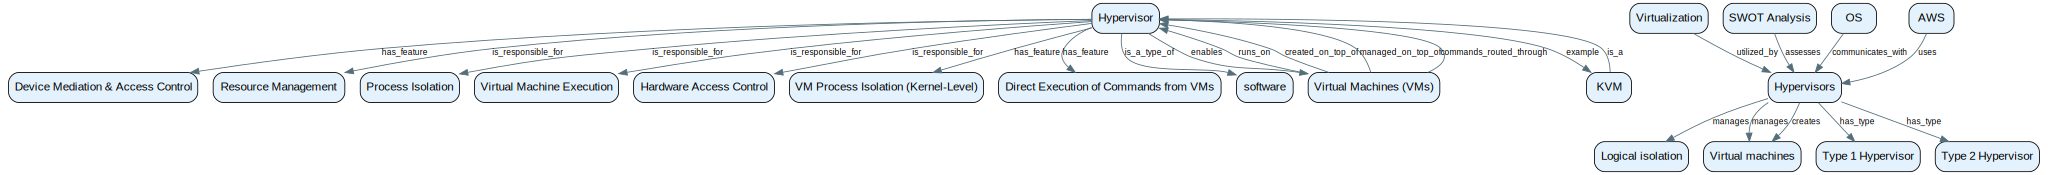

In [30]:
visualize_from_data(retrieved_entities, retrieved_connections)

## Vanilla RAG Pipeline (Baseline)
For comparison, this is our baseline Vanilla RAG. It performs the same initial vector search but does no graph traversal.

In [31]:
def vanilla_rag(query_text: str, k: int, client, gemini_client) -> str:
    """
    Performs a simple vanilla RAG retrieval.

    It finds the top-k semantically similar entities (acting as documents)
    based on the query and formats their properties into a single context string.
    This function does NOT perform any graph traversal.
    """
    # Retrieve the top K most relevant entities based on semantic similarity.
    top_entities = find_semantic_entry_points(query_text, k, client, gemini_client)

    # ormat the retrieved entities into a single context string.
    context_strings = []
    for entity in top_entities:
        context_strings.append(_format_entity_properties(entity))

    return "\n\n".join(context_strings)


We run the Vanilla RAG pipeline, retrieving 20 documents to match the context size of our Graph RAG test.

In [32]:
query = "What does a hypervisor do?"
k_documents = 20 # The number of top documents (entities) to retrieve. Here k is equivalent to the max_entities parameter in graph RAG above

vanilla_rag_context = vanilla_rag(
    query_text=query,
    k=k_documents,
    client=client,
    gemini_client=gemini_client
)

print("--- Generated Vanilla RAG Context ---")
print(vanilla_rag_context)

--- Generated Vanilla RAG Context ---
Entity: 'Hypervisor' (Class: 'Software', ID: 202)
  - access_control: Hypervisors emulate hardware devices, allowing VMs to interact with peripherals.
  - command_execution_method: Privileged Instructions from guest VMs (e.g., hardware access) must go through
  - definition: a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.
  - device_mediation: Hypervisors emulate hardware devices, allowing VMs to interact with peripherals.
  - hardware_access_control: Ensures that instructions requiring hardware access execute under the hypervisor’s control.
  - process_isolation: Ensures that VM processes do not interfere with each other’s memory space (prevents buffer overflow).
  - resource_allocation: Allocates CPU, memory, and storage to VMs efficiently.
  - role: software layer
  - vm_execution_management: All VMs are created and managed on top of a hypervisor.

Entity: 'Hyper

The resulting context and the query is similarly passed to the gemini-2.5-flash to generate the response.

In [33]:
response = gemini_client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"Use the given context to answer the user's query. \nQuery: {query}, \nRetrieved Contex: {vanilla_rag_context}"
)

answer = (response.text)

print(answer)

A hypervisor is a software layer that allows multiple virtual machines (VMs) to run on a single physical machine by abstracting hardware resources.

Its key functions include:
*   **Resource Allocation:** Allocates CPU, memory, and storage to VMs efficiently.
*   **VM Management:** Creates and manages all VMs.
*   **Hardware Emulation & Device Mediation:** Emulates hardware devices, allowing VMs to interact with peripherals.
*   **Hardware Access Control:** Ensures that instructions requiring hardware access execute under its control.
*   **Process Isolation:** Manages VM isolation, preventing VM processes from interfering with each other’s memory space.
*   **Command Execution Control:** Privileged instructions from guest VMs (e.g., hardware access) must go through the hypervisor.


I asked two separate reasoning LLMs, GPT-o3 and Gemini 2.5 Pro, to evaluate which response is better. I gave the query, response 1 (Graph RAG) and response 2 (Vanilla RAG).

# GPT o3

**Response 1** is stronger overall.

| Criterion                   | Response 1                                                                                                                                 | Response 2                                                                                 | Why Response 1 Wins                                                                                                                   |
| --------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------- |
| **Accuracy**                | Correctly identifies the four primary duties of a hypervisor (VM creation/management, resource allocation, hardware mediation, isolation). | Also accurate, but splits “hardware control” into two bullets that describe the same idea. | Both are factually right, but Response 2’s duplication (“Hardware Access Control” vs. “Command Execution Control”) blurs the message. |
| **Coverage vs. Redundancy** | Covers each responsibility once, so the list is complete yet compact.                                                                      | Adds two near-identical bullets, inflating the list to six items without new content.      | Concise lists are easier to scan and remember.                                                                                        |
| **Clarity & Flow**          | Orders tasks from “spin up VMs” → “allocate resources” → “mediate hardware” → “isolate VMs,” which matches the lifecycle of a VM.          | Starts with resources, then VM management, then jumps around.                              | Logical sequencing helps readers follow the story.                                                                                    |
| **Brevity**                 | Four bullets, each clearly worded.                                                                                                         | Six bullets, a bit repetitive.                                                             | Less text, same insight.                                                                                                              |
| **Style / Readability**     | Parallel phrasing and consistent formatting.                                                                                               | Good formatting, but redundancy hurts clarity.                                             | More polished and streamlined.                                                                                                        |

If you merged Response 2’s two redundant bullets or re-phrased them under a single “Privileged Instruction Handling” point, the two answers would be nearly identical. As written, though, Response 1 communicates the same information with fewer words and no duplication, so it’s the better pick.



# Gemini-2.5-pro

Response 1 is better.

Here's why:

* **Better Organization:** Response 1 groups related concepts more logically. For instance, it combines hardware emulation and privileged instruction control under the single, clear heading "Hardware Abstraction and Mediation." Response 2 splits these into three separate, overlapping points ("Hardware Emulation," "Hardware Access Control," and "Command Execution Control"), which is redundant and less clear.
* **More Concise:** By avoiding redundancy, Response 1 is more direct and easier to read.
* **Clarity:** The structure of Response 1 provides a clearer overview of a hypervisor's primary roles without getting bogged down in repetitive details.

# EVALS

Note: These eval queries' golden IDs are specific to this data. Since each time somewhat different entities and connections will be generated due to the non-deterministic nature of LLMs, these queries may not give good NUMERICAL metrics results for you. The LLM-as-a-judge evals, however will work.

If you are using your own data source, you get generate your own synthetic eval queries and golden ids by providing the generated entity documents from [part 1](https://colab.research.google.com/drive/1KTAa5n-v_8casxUrxP4PZVqOUbVwYo6I#scrollTo=3SlKRY8KgTL8) to an LLM, ask it to first generate some queries then map relevant k context entities' ids to the queries.

## Evaluation Part 1: Numerical Metrics

We'll first evaluate the two methods using standard retrieval metrics:

* **Precision@k:** Measures the fraction of retrieved items that are relevant.

$$
\text{Precision@k} = \frac{\left| \text{Retrieved} \cap \text{Golden} \right|}
                           {\left| \text{Retrieved} \right|}
$$

* **Recall@k:** Measures the fraction of relevant items that were successfully retrieved.

$$
\text{Recall@k} = \frac{\left| \text{Retrieved} \cap \text{Golden} \right|}
                       {\left| \text{Golden} \right|}
$$

* **Mean Average Precision (MAP):** The mean of Average Precision (AP) scores across all queries.  
  AP rewards ranking relevant items higher in the list.

$$
\text{AP} = \frac{\displaystyle \sum_{k=1}^{n}
                 \bigl(P(k)\,\times\,\text{rel}(k)\bigr)}
                 {\text{Number of relevant documents}}
$$

where $P(k)$ is the precision at cut-off $k$ and $\text{rel}(k)$ is 1 if the item at rank $k$ is relevant, 0 otherwise.

### Evaluation Set
We use a predefined set of 10 queries and a corresponding "golden set" of ideal entity IDs for each.

Note that we need the returned entities' entity ids from each RAG method to compute our evaluaion metrics.

In [99]:
eval_queries = [
  "Explain how the core concept of 'Virtualization' enables the on-demand resource provisioning provided by the 'Elastic Compute Cloud (EC2)' service.",
  "Describe the relationship between a 'Type 2 Hypervisor' and the host 'Operating System' it runs on, and why this dependency is considered a security weakness compared to a 'Type 1 Hypervisor'.",
  "How do the 'Identity Service' and 'Compute Service' within OpenStack collaborate to manage the lifecycle of a virtual machine requested by a user?",
  "Trace the connection from the 'IaaS' service model down to the specific components like 'Virtual Machines' and 'Applications' that a 'User' is responsible for managing.",
  "Explain how the 'para-virtualization' model, used by the 'Xen' hypervisor, requires guest 'OS' modification to achieve higher performance.",
  "Describe how a 'Virtual Private Cloud (VPC)' and 'Network Policies' work together to provide logical isolation on shared physical hardware.",
  "Compare 'Clusters' and 'Grids' by detailing their differing approaches to 'homogeneity', 'geographical distribution', and 'middleware' complexity.",
  "What is the role of a 'Cloud Auditor' in ensuring the 'Security' and 'compliance' of a 'Cloud Service Provider'?",
  "Starting from the 'On-Demand Self-Service' concept, explain how a user can interact with a 'web interface' to utilize cloud resources without direct operator intervention.",
  "Describe the link between the 'Microservices Architecture' concept and 'Containers', and explain how this pairing enables the creation of scalable 'Cloud-Native Applications'."
]

In [100]:
golden_ids = {
  "0": [20, 287, 13, 16, 202, 197, 87, 46, 303, 15, 293, 149, 104, 47, 66],
  "1": [207, 195, 203, 83, 40, 202, 225, 85, 208, 204, 269, 59, 29, 77, 84],
  "2": [345, 343, 178, 73, 197, 260, 282, 346, 131, 104, 342, 283, 136, 350, 261],
  "3": [293, 260, 33, 197, 199, 195, 32, 74, 87, 34, 292, 267, 35, 36, 311],
  "4": [80, 206, 195, 96, 79, 202, 213, 225, 78, 203, 173, 205, 26, 82, 84],
  "5": [359, 360, 111, 269, 112, 371, 372, 368, 110, 175, 51, 370, 379, 380, 164],
  "6": [143, 144, 19, 31, 192, 138, 151, 149, 147, 153, 152, 358, 5, 27, 28],
  "7": [300, 40, 245, 29, 38, 252, 256, 117, 118, 169, 41, 33, 301, 298, 299],
  "8": [13, 260, 24, 262, 14, 342, 146, 149, 194, 212, 261, 73, 303, 289, 264],
  "9": [89, 86, 88, 44, 16, 214, 193, 28, 132, 218, 217, 306, 42, 149, 93]
}

A function to retrieve entity ids of entities fetched and traversed using the above-defined graph RAG function.

In [101]:
def retrieve_graph_rag_ids(query_text: str, k: int, max_hops: int, max_entities: int, client, gemini_client) -> List[int]:
    """
    Runs the Graph RAG process to retrieve only the entity IDs.

    """
    # We call the modified graph_rag function to get the structured data
    _, retrieved_entities_dict, _ = graph_rag(
        query_text=query_text,
        k=k,
        max_hops=max_hops,
        max_entities=max_entities,
        client=client,
        gemini_client=gemini_client
    )
    # The keys of the entities dictionary are the unique entity IDs collected
    retrieved_ids = list(retrieved_entities_dict.keys())
    print("\nGraph RAG ids: ", retrieved_ids)
    return retrieved_ids

A function to retrieve entity ids of entities fetched using the above-defined vanilla RAG function.

In [102]:
def retrieve_vanilla_rag_ids(query_text: str, k: int, client, gemini_client) -> List[int]:
    """
    Runs the core logic of Vanilla RAG to retrieve only the entity IDs.

    """
    # find_semantic_entry_points returns a list of entity dictionaries
    retrieved_entities = find_semantic_entry_points(query_text, k, client, gemini_client)
    # Extract just the 'id' from each dictionary
    retrieved_ids = [entity.get('id') for entity in retrieved_entities if entity.get('id') is not None]
    print("\nVanilla RAG ids: ", retrieved_ids)
    return retrieved_ids

Helper functions to calculate vector search metrics.

In [103]:
def calculate_precision(retrieved: List[int], golden: List[int]) -> float:
    """Calculates precision: |retrieved & golden| / |retrieved|"""
    if not retrieved:
        return 0.0

    retrieved_set = set(retrieved)
    golden_set = set(golden)
    intersection = retrieved_set.intersection(golden_set)

    return len(intersection) / len(retrieved_set)

def calculate_recall(retrieved: List[int], golden: List[int]) -> float:
    """Calculates recall: |retrieved & golden| / |golden|"""
    if not golden:
        return 0.0

    retrieved_set = set(retrieved)
    golden_set = set(golden)
    intersection = retrieved_set.intersection(golden_set)

    return len(intersection) / len(golden_set)

def calculate_average_precision(retrieved: List[int], golden: List[int]) -> float:
    """Calculates Mean Average Precision (MAP), which rewards correct ranking."""
    if not golden:
        return 0.0

    golden_set = set(golden)
    hits = 0
    sum_of_precisions = 0.0

    for i, p in enumerate(retrieved):
        if p in golden_set:
            hits += 1
            sum_of_precisions += hits / (i + 1)

    return sum_of_precisions / len(golden_set)

Lets define a function to run our evauation. We use k = 15. This the max amount of entities to be used for evauation. This is the same as the amount of golden ids for each query in the svaluation set.
The initial k for graoh RAG is set as 5 so 1/3 entities for graph RAG are through vector search and the remaining 2/3 are fetched via graph traversal with max hops configured to 2.

In [104]:
def run_evaluation(eval_queries: List[str], golden_ids: Dict[str, List[int]], client, gemini_client):
    """
    Orchestrates the evaluation process for both Vanilla and Graph RAG.
    """
    vanilla_results = {}
    graph_results = {}

    # Define evaluation parameters
    RETRIEVAL_BUDGET = 15 # this is the k for vanilla RAG and max_entities for graph RAG
    GRAPH_RAG_K_INITIAL = 5
    GRAPH_RAG_MAX_HOPS = 2

    for i, query in enumerate(tqdm(eval_queries, desc="Evaluating Queries")):
        query_id = str(i)
        golden_set = golden_ids[query_id]

        # Evaluate Vanilla RAG
        vanilla_retrieved = retrieve_vanilla_rag_ids(query, RETRIEVAL_BUDGET, client, gemini_client)
        vanilla_results[query_id] = {
            'precision': calculate_precision(vanilla_retrieved, golden_set),
            'recall': calculate_recall(vanilla_retrieved, golden_set),
            'average_precision': calculate_average_precision(vanilla_retrieved, golden_set)
        }

        # Evaluate Graph RAG
        graph_retrieved = retrieve_graph_rag_ids(
            query,
            k=GRAPH_RAG_K_INITIAL,
            max_hops=GRAPH_RAG_MAX_HOPS,
            max_entities=RETRIEVAL_BUDGET,
            client=client,
            gemini_client=gemini_client
        )
        graph_results[query_id] = {
            'precision': calculate_precision(graph_retrieved, golden_set),
            'recall': calculate_recall(graph_retrieved, golden_set),
            'average_precision': calculate_average_precision(graph_retrieved, golden_set)
        }

    return vanilla_results, graph_results

Helper function to display the evaluation results.

In [105]:
def display_evaluation_results(vanilla_results: dict, graph_results: dict):
    """Calculates and prints the mean of the metrics in a formatted table."""

    def calculate_means(results: dict):
        num_queries = len(results)
        if num_queries == 0:
            return {'precision': 0, 'recall': 0, 'map': 0}

        mean_p = sum(res['precision'] for res in results.values()) / num_queries
        mean_r = sum(res['recall'] for res in results.values()) / num_queries
        mean_ap = sum(res['average_precision'] for res in results.values()) / num_queries

        return {'precision': mean_p, 'recall': mean_r, 'map': mean_ap}

    vanilla_means = calculate_means(vanilla_results)
    graph_means = calculate_means(graph_results)

    print("\n" + "="*50)
    print("           Retrieval Evaluation Summary")
    print("="*50)
    print(f"{'Metric':<20} | {'Vanilla RAG':<15} | {'Graph RAG':<15}")
    print("-"*50)
    print(f"{'Precision':<20} | {vanilla_means['precision']:<15.4f} | {graph_means['precision']:<15.4f}")
    print(f"{'Recall':<20} | {vanilla_means['recall']:<15.4f} | {graph_means['recall']:<15.4f}")
    print(f"{'MAP (Rank-Aware)':<20} | {vanilla_means['map']:<15.4f} | {graph_means['map']:<15.4f}")
    print("="*50)

Lets run our evals.

In [106]:
vanilla_results, graph_results = run_evaluation(eval_queries, golden_ids, client, gemini_client)
display_evaluation_results(vanilla_results, graph_results)

Evaluating Queries:  10%|█         | 1/10 [00:00<00:05,  1.80it/s]


Vanilla RAG ids:  [287, 20, 149, 46, 202, 49, 16, 66, 60, 314, 51, 146, 52, 341, 58]

Graph RAG ids:  [287, 20, 149, 46, 202, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]


Evaluating Queries:  20%|██        | 2/10 [00:00<00:03,  2.19it/s]


Vanilla RAG ids:  [83, 207, 203, 202, 209, 72, 208, 62, 205, 200, 79, 206, 204, 85, 66]

Graph RAG ids:  [83, 207, 203, 202, 209, 44, 47, 58, 59, 62, 65, 66, 67, 70, 71]

Vanilla RAG ids:  [343, 345, 287, 319, 283, 346, 282, 351, 73, 136, 311, 293, 350, 321, 341]


Evaluating Queries:  30%|███       | 3/10 [00:01<00:03,  2.23it/s]


Graph RAG ids:  [343, 345, 287, 319, 283, 16, 47, 104, 105, 106, 107, 110, 131, 66, 73]

Vanilla RAG ids:  [293, 311, 295, 294, 119, 296, 260, 34, 287, 313, 136, 66, 32, 343, 33]


Evaluating Queries:  40%|████      | 4/10 [00:01<00:02,  2.45it/s]


Graph RAG ids:  [293, 311, 295, 294, 119, 117, 178, 193, 256, 287, 260, 6, 8, 13, 14]

Vanilla RAG ids:  [80, 206, 79, 202, 205, 213, 207, 71, 200, 66, 203, 72, 157, 52, 61]


Evaluating Queries:  50%|█████     | 5/10 [00:02<00:01,  2.58it/s]


Graph RAG ids:  [80, 206, 79, 202, 205, 42, 47, 65, 66, 67, 70, 71, 72, 78, 87]

Vanilla RAG ids:  [360, 368, 359, 110, 367, 121, 311, 51, 202, 344, 366, 76, 65, 345, 370]


Evaluating Queries:  60%|██████    | 6/10 [00:02<00:01,  2.75it/s]


Graph RAG ids:  [360, 368, 359, 110, 367, 40, 111, 164, 179, 229, 240, 252, 322, 344, 345]

Vanilla RAG ids:  [143, 144, 152, 19, 192, 138, 153, 15, 31, 149, 260, 146, 5, 156, 157]


Evaluating Queries:  70%|███████   | 7/10 [00:02<00:01,  2.71it/s]


Graph RAG ids:  [143, 144, 152, 19, 192, 5, 15, 40, 47, 96, 142, 145, 146, 147, 149]

Vanilla RAG ids:  [300, 245, 252, 33, 257, 169, 253, 17, 32, 345, 146, 149, 286, 256, 34]


Evaluating Queries:  80%|████████  | 8/10 [00:03<00:00,  2.77it/s]


Graph RAG ids:  [300, 245, 252, 33, 257, 15, 32, 34, 35, 36, 38, 39, 40, 43, 96]

Vanilla RAG ids:  [13, 146, 260, 24, 14, 149, 295, 27, 287, 298, 16, 342, 15, 32, 296]


Evaluating Queries:  90%|█████████ | 9/10 [00:03<00:00,  2.82it/s]


Graph RAG ids:  [13, 146, 260, 24, 14, 6, 8, 15, 32, 34, 36, 38, 47, 121, 87]

Vanilla RAG ids:  [89, 88, 86, 193, 93, 215, 306, 214, 217, 149, 132, 218, 50, 91, 119]


Evaluating Queries: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Graph RAG ids:  [89, 88, 86, 193, 93, 40, 60, 87, 90, 91, 92, 94, 149, 153, 174]

           Retrieval Evaluation Summary
Metric               | Vanilla RAG     | Graph RAG      
--------------------------------------------------
Precision            | 0.5000          | 0.3933         
Recall               | 0.5000          | 0.3933         
MAP (Rank-Aware)     | 0.4366          | 0.3388         


The results show that **Vanilla RAG scores higher** on these metrics.

This is because these metrics measure simple ID overlap. Vanilla RAG's strategy is 100% optimized for this (retrieving the top 15 most similar items through pure vector search), while Graph RAG's strategy involves exploring structurally-related nodes that may be less semantically similar, thus lowering its overlap score. This highlights the limitations of using these metrics alone to judge the *utility* of a retrieved context.
These metrics also do not reflect the cost and speed optimisation provided by graph traversal over vector search.

## Evaluation Part 2: LLM-as-a-Judge

Given the limitations of numerical metrics, we'll use a more qualitative approach. An LLM-as-a-Judge will evaluate the **quality of the final generated answer** from each RAG method. This better reflects the true performance of the system.

**The Process:**
1.  Generate an answer using the Vanilla RAG context.
2.  Generate an answer using the Graph RAG context.
3.  Have a powerful reasoning LLM act as a judge and vote for the better answer.

For the answer generation, we use [`gemini-2.5-flash`](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-flash), whereas [`gemini-2.5-pro`](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro) is best-suited to be the judge.

For the answer generation, the LLM is simple provided the query + the retrieved context and is prompted to generate the answer based solely on that context.

The judge LLM is instructed to only respond with the choice 1 (for vanilla RAG response preference) or 2 (for graph RAG response preference).

In [112]:
def generate_answer(query: str, context: str, generator_client) -> str:
    """
    Generates an answer to a query using the provided context.
    Uses the gemini-2.5-flash model for speed and efficiency.
    """
    prompt = (
        "Based only on the provided context, answer the following query concisely. "
        "If the context does not contain the answer, state that you cannot answer based on the information given.\n\n"
        f"Query: {query}\n\n"
        f"Context:\n{context}\n\n"
        "Answer:"
    )

    try:
        # Use the gemini_client already initialized
        response = generator_client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
        print(response.text)
        return response.text
    except Exception as e:
        print(f"An error occurred during answer generation: {e}")
        return "Error: Could not generate an answer."

def judge_answers(query: str, answer_1: str, answer_2: str, judge_client) -> int:
    """
    Asks a powerful LLM judge to decide which of two answers is better.
    Uses gemini-2.5-pro for its strong reasoning capabilities.
    Returns 1 for Answer 1 or 2 for Answer 2.
    """
    prompt = (
        "You are an impartial judge. Your task is to evaluate two AI-generated answers to a user's query and determine which is better. "
        "Consider correctness, completeness, and clarity. Length doesn't matter - a shorter answer may be better than a longer one and vice versa. Penalise irrelevant remarks.\n\n"
        f"USER QUERY:\n'{query}'\n\n"
        "--- ANSWER 1 ---\n"
        f"{answer_1}\n\n"
        "--- ANSWER 2 ---\n"
        f"{answer_2}\n\n"
        "--- INSTRUCTIONS ---\n"
        "Output only the number of the better answer: '1' or '2'."
    )

    try:
        # Use the gemini_client for the judge model
        response = judge_client.models.generate_content(
            model="gemini-2.5-pro",
            contents=prompt
        )

        # Parse the last line of the response to get the deterministic vote
        last_line = response.text.strip().split('\n')[-1].strip()
        if last_line == "1":
            return 1
        elif last_line == "2":
            return 2
        else:
            # If the model fails to follow instructions, default to 0.
            return 0
    except Exception as e:
        print(f"An error occurred during judging: {e}")
        return 0 # Return 0 for error

We define the orchestration function to run the LLM-as-a-Judge evals.

In [113]:
def run_llm_as_judge_evaluation(eval_queries: List[str], client, gemini_client):
    """
    Orchestrates the end-to-end evaluation using an LLM-as-a-Judge.
    """
    scores = {"vanilla_wins": 0, "graph_wins": 0, "errors": 0}

    # Define RAG parameters for this evaluation ---
    VANILLA_K = 15
    GRAPH_K_INITIAL = 5
    GRAPH_MAX_HOPS = 2
    GRAPH_MAX_ENTITIES = 15

    print("--- Starting LLM-as-a-Judge Evaluation ---")

    for query in tqdm(eval_queries, desc="Judging Queries"):
        # Get contexts from both RAG methods
        vanilla_context = vanilla_rag(query, VANILLA_K, client, gemini_client)
        graph_context, _, _ = graph_rag(
            query, GRAPH_K_INITIAL, GRAPH_MAX_HOPS, GRAPH_MAX_ENTITIES, client, gemini_client
        )

        # Generate an answer for each context
        print(f"\nGenerating answers for query: '{query[:50]}...'")
        answer_vanilla = generate_answer(query, vanilla_context, gemini_client)
        answer_graph = generate_answer(query, graph_context, gemini_client)

        # Have the judge decide which answer is better
        vote = judge_answers(query, answer_vanilla, answer_graph, gemini_client)

        # Tally the votes
        if vote == 1:
            scores["vanilla_wins"] += 1
            print(">> Judge voted for: Vanilla RAG")
        elif vote == 2:
            scores["graph_wins"] += 1
            print(">> Judge voted for: Graph RAG")
        else:
            scores["errors"] += 1
            print(">> Failed to vote.")

    print("\n--- LLM-as-a-Judge Evaluation Complete ---")
    return scores


Helper function to display theresults of the LLM-as-a-Judge evals.

In [114]:
def display_judge_results(scores: dict):
    """Prints the final scorecard from the LLM-as-a-Judge evaluation."""
    total_queries = sum(scores.values())

    print("\n" + "="*50)
    print("           LLM-as-a-Judge Final Scorecard")
    print("="*50)
    print(f"Total Queries Judged: {total_queries}")
    print(f"Vanilla RAG Wins:     {scores['vanilla_wins']}")
    print(f"Graph RAG Wins:       {scores['graph_wins']}")
    print(f"Errors:       {scores['errors']}")
    print("="*50)

    if scores['graph_wins'] > scores['vanilla_wins']:
        print("\nVerdict: Graph RAG produced higher-quality answers.")
    elif scores['vanilla_wins'] > scores['graph_wins']:
        print("\nVerdict: Vanilla RAG produced higher-quality answers.")
    else:
        print("\nVerdict: It's a tie!")

Lets run the evals and collect the scores.

In [131]:
judge_scores = run_llm_as_judge_evaluation(eval_queries, client, gemini_client)

--- Starting LLM-as-a-Judge Evaluation ---


Judging Queries:   0%|          | 0/10 [00:00<?, ?it/s]


Generating answers for query: 'Explain how the core concept of 'Virtualization' e...'
Virtualization enables EC2's on-demand resource provisioning by allowing the creation of virtual machines (VMs) from physical resources. Hypervisors, which utilize virtualization, create and manage these VMs, allowing multiple VMs to run on a single physical machine while efficiently allocating CPU, memory, and storage. This capability supports EC2's provision of virtual machines with on-demand resource allocation and rapid elasticity.
Virtualization enables on-demand resource provisioning for EC2 by allowing the creation of virtual machines (VMs) from underlying physical resources, thereby efficiently utilizing key resources. This capability is a key enabler for 'Rapid Elasticity', which allows resources to scale up or down dynamically based on demand, and 'Resource Pooling', where physical resources are combined into a shared pool for on-demand allocation and reallocation. EC2 leverages these aspec

Judging Queries:  10%|█         | 1/10 [00:21<03:09, 21.02s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Describe the relationship between a 'Type 2 Hyperv...'
A 'Type 2 Hypervisor' runs on top of an existing host 'Operating System' and depends on it for execution and hardware access. This dependency is considered a security weakness because it introduces additional risk and security vulnerabilities due to its reliance on the host OS. In contrast, a 'Type 1 Hypervisor' is more secure as it runs directly on the physical hardware without an underlying OS.
A Type 2 Hypervisor runs on top of an existing Operating System (OS) and depends on the host OS for execution and management of hardware access.

This dependency is considered a security weakness compared to a Type 1 Hypervisor because it introduces additional risk and security vulnerabilities due to its reliance on the host OS. A Type 1 Hypervisor, conversely, runs directly on the physical hardware without an underlying OS, making it more secure.


Judging Queries:  20%|██        | 2/10 [00:38<02:29, 18.69s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'How do the 'Identity Service' and 'Compute Service...'
The provided context describes the individual roles of the 'Identity Service' (authentication and authorization) and the 'Compute Service' (manages VM lifecycle), but it does not detail how they collaborate to manage the lifecycle of a virtual machine requested by a user.
The 'Identity Service' provides authentication and authorization and ensures access controls for a user's request to create a virtual machine. Once authorized, the 'Compute Service' manages the lifecycle of the virtual machine, including its creation.


Judging Queries:  30%|███       | 3/10 [00:51<01:54, 16.39s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Trace the connection from the 'IaaS' service model...'
Based only on the provided context, I cannot fully trace the connection from 'IaaS' down to the specific components 'Virtual Machines' and 'Applications' that a 'User' is responsible for managing.

The context states that for 'IaaS', a 'User' is responsible to "build entire cloud-based infrastructure" or "build their infrastructure". 'Elastic Compute Cloud (EC2)' is identified as an 'IaaS' service that "provides virtual machines (VMs)". However, the context does not explicitly state that the 'User' is responsible for *managing* these 'Virtual Machines' or 'Applications' within the IaaS model, beyond building the infrastructure. It only mentions building the infrastructure and IaaS providing VMs. For 'Applications', the context for other service models (SaaS, PaaS) explicitly states users *do not* manage applications.
Under the 'Infrastructure as a Service (IaaS)' service

Judging Queries:  40%|████      | 4/10 [01:22<02:13, 22.22s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'Explain how the 'para-virtualization' model, used ...'
The 'para-virtualization' model, used by 'Xen', requires guest 'OS' modification because the guest 'OS' must be adapted to communicate with the hypervisor directly. This direct hypervisor interaction leads to higher performance due to lower overhead.
The 'para-virtualization' model, used by the 'Xen' hypervisor, requires guest OS modification to achieve higher performance because the guest OS must be modified to communicate directly with the hypervisor. This direct interaction leads to lower overhead and thus higher performance.


Judging Queries:  50%|█████     | 5/10 [01:49<01:58, 23.78s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Describe how a 'Virtual Private Cloud (VPC)' and '...'
A Virtual Private Cloud (VPC) provides a logically isolated section within AWS on shared physical hardware (as multiple virtual networks can operate on shared physical infrastructure). Network Policies then work to ensure isolation within that VPC.
A Virtual Private Cloud (VPC) provides a logically isolated section within AWS, offering dedicated cloud space for clients and logical network isolation. Network Policies ensure isolation specifically *within* this VPC. Together, the VPC establishes the isolated environment, and Network Policies enforce isolation rules inside that environment.


Judging Queries:  60%|██████    | 6/10 [02:08<01:28, 22.10s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Compare 'Clusters' and 'Grids' by detailing their ...'
**Homogeneity:**
*   **Clusters:** Consist of machines with the same type of hardware and OS, making them homogeneous.
*   **Grids:** Consist of heterogeneous systems that may have different hardware, OS, and configurations.

**Geographical Distribution:**
*   **Clusters:** All machines are geographically close and in the same environment.
*   **Grids:** Are geographically distributed.

**Middleware Complexity:**
*   **Clusters:** Have fewer middleware complexities.
*   **Grids:** Middleware has to handle diverse configurations, leading to potential performance degradation.
**Homogeneity:**
*   **Clusters:** All machines have the same type of hardware and OS (homogeneous).
*   **Grids:** Consist of heterogeneous systems that may have different hardware, OS, and configurations.

**Geographical Distribution:**
*   **Clusters:** All machines are geographically close and in 

Judging Queries:  70%|███████   | 7/10 [02:18<00:55, 18.37s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'What is the role of a 'Cloud Auditor' in ensuring ...'
A 'Cloud Auditor' ensures 'security compliance' and 'security and reliability' for cloud providers.
The role of a 'Cloud Auditor' in ensuring the 'Security' and 'compliance' of a 'Cloud Service Provider' is to audit the security compliance of the provider and ensure security and reliability. Auditors must be independent and not internally controlled by the cloud provider.


Judging Queries:  80%|████████  | 8/10 [02:32<00:33, 16.95s/it]

>> Judge voted for: Graph RAG

Generating answers for query: 'Starting from the 'On-Demand Self-Service' concept...'
Starting from the 'On-Demand Self-Service' concept, users can configure and deploy services independently, without requiring human intervention or waiting for an operator. This is possible because services are already deployed and provided via a 'web interface'. Users interact with the cloud system through this web interface to utilize cloud resources directly, without needing direct access to computing resources or operator intervention.
Starting from the 'On-Demand Self-Service' concept, users can configure and deploy services independently, without requiring human intervention. This is enabled because services are already deployed and provided via a 'web interface'. Users then interact with this 'web interface' to utilize cloud resources, eliminating the need for direct operator intervention.


Judging Queries:  90%|█████████ | 9/10 [02:51<00:17, 17.51s/it]

>> Judge voted for: Vanilla RAG

Generating answers for query: 'Describe the link between the 'Microservices Archi...'
The 'Microservices Architecture' concept involves splitting applications into "small, independent services". 'Containers' are lightweight, provide "an isolated environment to run specific applications", and "can be created and destroyed rapidly".

This pairing enables the creation of scalable 'Cloud-Native Applications' by allowing each "small, independent service" (microservice) to be packaged and run within its own "lightweight" container. Since 'Containers' are "more elastic than virtual machines" and can be rapidly created or destroyed, they facilitate the independent scaling of individual microservices. This aligns with the "Highly Scalable" and "Flexible" characteristics of 'Cloud-Native Applications' and allows the architecture to "leverage cloud elasticity".
The context indicates that 'Cloud-Native Applications' are "built using" both 'Microservices Architectur

Judging Queries: 100%|██████████| 10/10 [03:23<00:00, 20.33s/it]

>> Judge voted for: Vanilla RAG

--- LLM-as-a-Judge Evaluation Complete ---


The moment of truth - lets display the results.

In [132]:
display_judge_results(judge_scores)


           LLM-as-a-Judge Final Scorecard
Total Queries Judged: 10
Vanilla RAG Wins:     4
Graph RAG Wins:       6
Errors:       0

Verdict: Graph RAG produced higher-quality answers.


The final scorecard shows that **Graph RAG is the winner.**

This result demonstrates that while its retrieved context had less direct overlap with the golden set, the structure and rich connections within that context enabled the generator LLM to produce superior, more helpful answers. This confirms the value of Graph RAG in a way that the numerical metrics could not.